In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tkinter as tk
from tkinter import messagebox

from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [3]:
BINARY_FEATURES = ['Gender', 'Smoking', 'CancerHistory', 'Diagnosis']
CONTINUOUS_FEATURES = ['Age', 'BMI', 'PhysicalActivity', 'AlcoholIntake']
CATEGORICAL_FEATURES = ['GeneticRisk']

MODELS = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

# The final chosen model after cross-validation
best_model = None
best_model_name = None
scaler = None

In [4]:
# 1) DATA LOADING & EXPLORATION FUNCTIONS
df = pd.read_csv("cancer_data.csv")

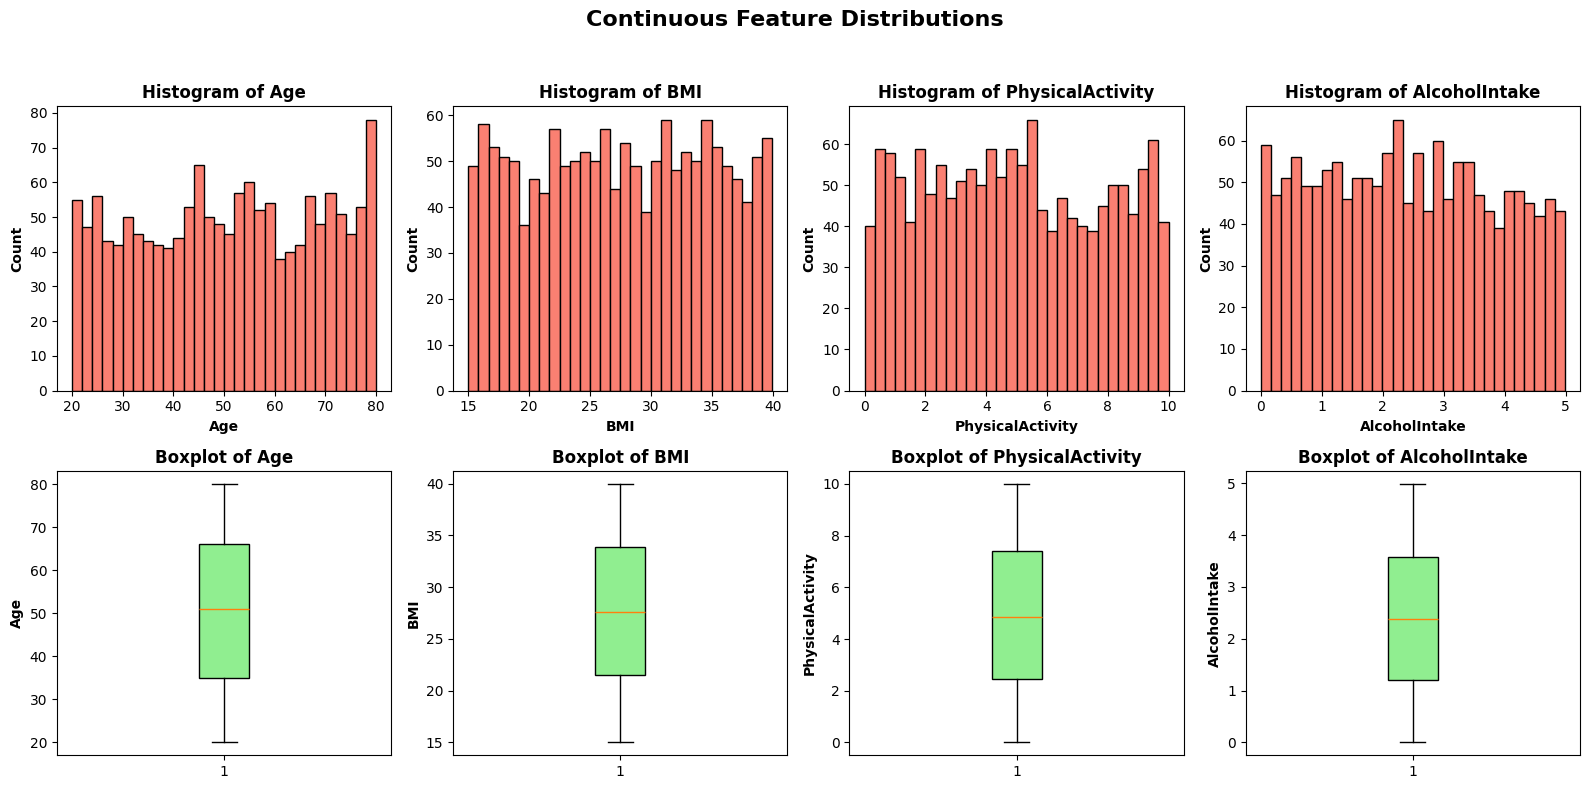

In [5]:
# Quick optional plots:
# 1. Histograms & Boxplots in one figure for continuous features
fig, axes = plt.subplots(2, len(CONTINUOUS_FEATURES), figsize=(16, 8))
fig.suptitle('Continuous Feature Distributions', fontsize=16, fontweight='bold')
for i, feat in enumerate(CONTINUOUS_FEATURES):
    ax_hist = axes[0, i]
    # Changed color from 'skyblue' to 'salmon'
    ax_hist.hist(df[feat].dropna(), bins=30, color='salmon', edgecolor='black')
    ax_hist.set_title(f'Histogram of {feat}', fontsize=12, fontweight='bold')
    ax_hist.set_xlabel(feat, fontsize=10, fontweight='bold')
    ax_hist.set_ylabel('Count', fontsize=10, fontweight='bold')

    ax_box = axes[1, i]
    # Changed facecolor from 'skyblue' to 'lightgreen'
    ax_box.boxplot(df[feat].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen'))
    ax_box.set_title(f'Boxplot of {feat}', fontsize=12, fontweight='bold')
    ax_box.set_ylabel(feat, fontsize=10, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\Tusha\AppData\Local\Temp\ipykernel_15240\2314763014.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
C:\Users\Tusha\AppData\Local\Temp\ipykernel_15240\2314763014.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
C:\Users\Tusha\AppData\Local\Temp\ipykernel_15240\2314763014.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
C:\Users\Tusha\AppData\Local\Temp\ipykernel_15240\2314763014.

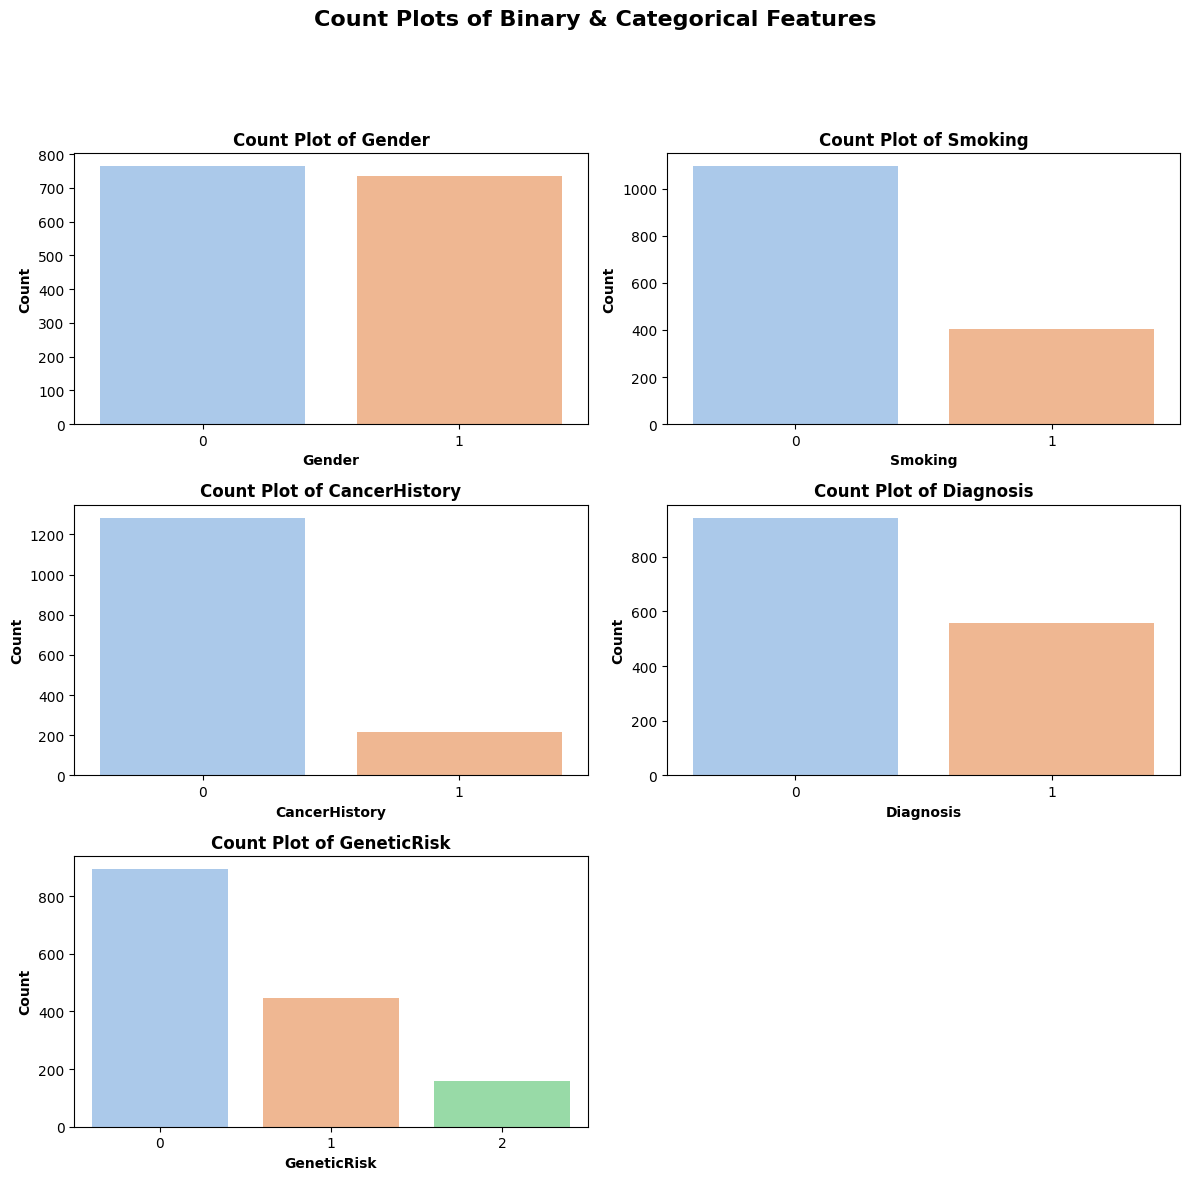

In [6]:
# 2. Count plots of binary + categorical in one figure
all_cat_feats = BINARY_FEATURES + CATEGORICAL_FEATURES
num_cat_feats = len(all_cat_feats)
rows = math.ceil(num_cat_feats / 2)
cols = 2 if num_cat_feats > 1 else 1

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
fig.suptitle('Count Plots of Binary & Categorical Features', fontsize=16, fontweight='bold')
axes = axes.flatten() if num_cat_feats > 1 else [axes]
for i, col in enumerate(all_cat_feats):
    # Changed palette from 'Set2' to 'pastel'
    sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
    axes[i].set_title(f"Count Plot of {col}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10, fontweight='bold')
    axes[i].set_ylabel("Count", fontsize=10, fontweight='bold')
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

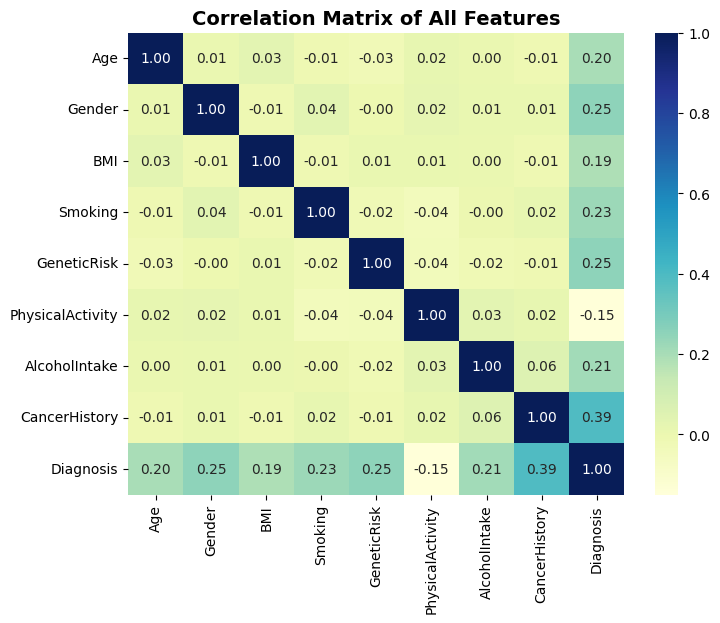

In [7]:
# 3. Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Matrix of All Features", fontsize=14, fontweight='bold')
plt.show()

In [8]:
# 2) PREPROCESS, TRAIN, AND SELECT BEST MODEL
global best_model, best_model_name, scaler

# Split X, y
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Scale continuous features
scaler = StandardScaler()
X[CONTINUOUS_FEATURES] = scaler.fit_transform(X[CONTINUOUS_FEATURES])

# Cross-validation to pick best model by accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for mname, model in MODELS.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    results.append({
        'Model': mname,
        'CV_Accuracy_Mean': np.mean(scores),
        'CV_Accuracy_Std': np.std(scores)
    })
results_df = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(results_df)

c:\Users\Tusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Tusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:47] WARNING: C:\actio

[LightGBM] [Info] Number of positive: 445, number of negative: 755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370833 -> initscore=-0.528643
[LightGBM] [Info] Start training from score -0.528643
[LightGBM] [Info] Number of positive: 445, number of negative: 755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370833 -> initscore=-0.528643
[LightGBM] [Info


Best model: CatBoost with mean CV accuracy=0.9440


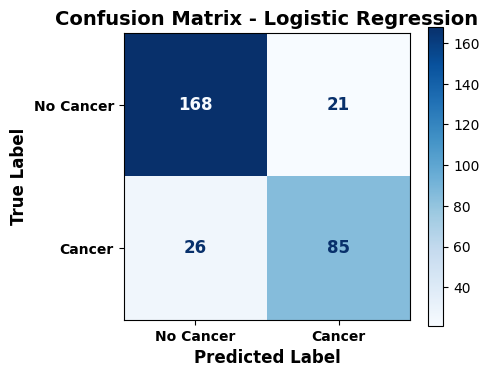

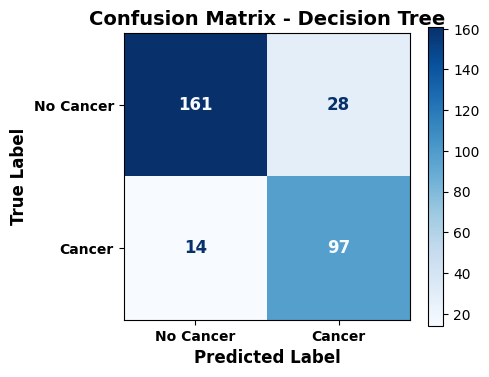

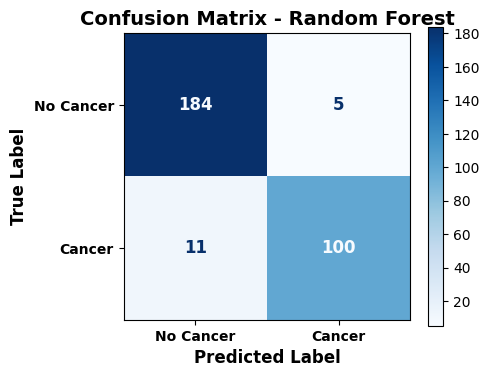

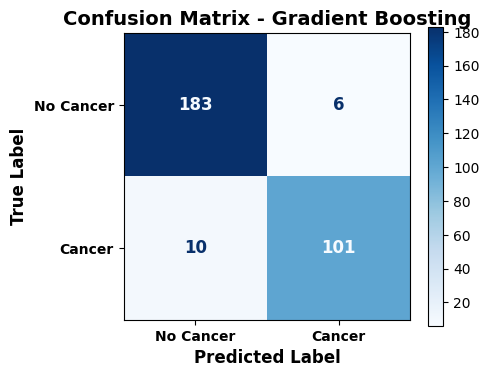

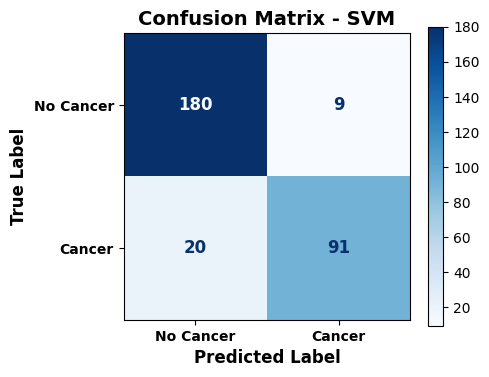

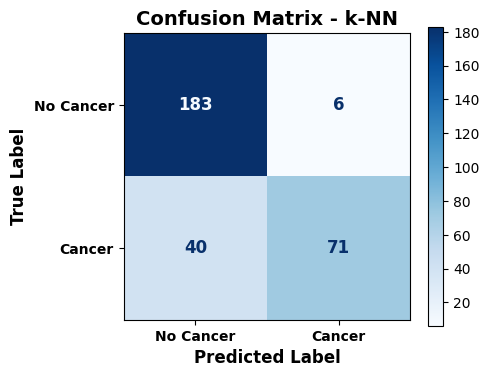

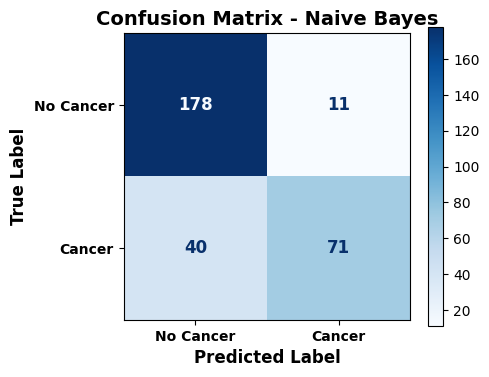

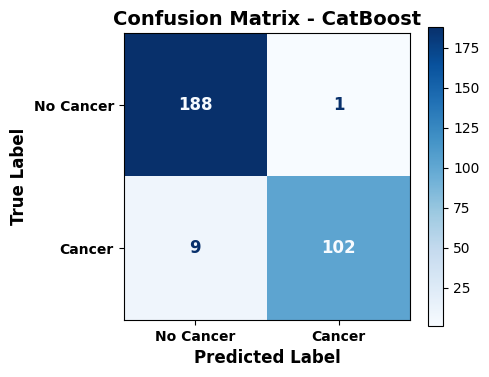

c:\Users\Tusha\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:06:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


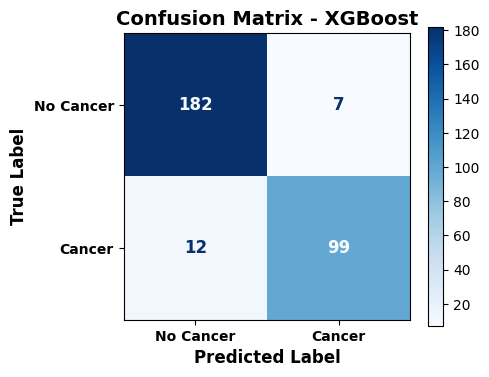

[LightGBM] [Info] Number of positive: 446, number of negative: 754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371667 -> initscore=-0.525073
[LightGBM] [Info] Start training from score -0.525073


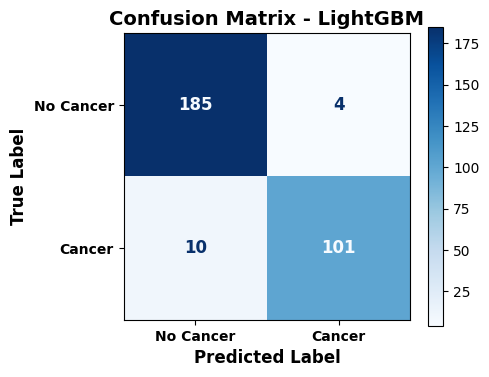


=== Test Set Results ===
                 Model  Test_Accuracy  Test_Precision  Test_Recall   Test_F1
0  Logistic Regression       0.843333        0.801887     0.765766  0.783410
1        Decision Tree       0.860000        0.776000     0.873874  0.822034
2        Random Forest       0.946667        0.952381     0.900901  0.925926
3    Gradient Boosting       0.946667        0.943925     0.909910  0.926606
4                  SVM       0.903333        0.910000     0.819820  0.862559
5                 k-NN       0.846667        0.922078     0.639640  0.755319
6          Naive Bayes       0.830000        0.865854     0.639640  0.735751
7             CatBoost       0.966667        0.990291     0.918919  0.953271
8              XGBoost       0.936667        0.933962     0.891892  0.912442
9             LightGBM       0.953333        0.961905     0.909910  0.935185
Results saved to 'cross_validation_results.csv' and 'test_set_results.csv'.


In [9]:
# Pick best model
best_row = results_df.iloc[results_df['CV_Accuracy_Mean'].idxmax()]
best_model_name = best_row['Model']
print(f"\nBest model: {best_model_name} with mean CV accuracy={best_row['CV_Accuracy_Mean']:.4f}")

best_model = MODELS[best_model_name]
best_model.fit(X, y)  # retrain on all data

# (Optional) Evaluate on train-test split and show confusion matrix
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

# Evaluate each model on test set
test_res = []
for mname, model in MODELS.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    test_res.append({
        'Model': mname,
        'Test_Accuracy': acc,
        'Test_Precision': prec,
        'Test_Recall': rec,
        'Test_F1': f1
    })

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer','Cancer'])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix - {mname}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontsize=10, fontweight='bold')
    for text in disp.text_.ravel():
        text.set_fontsize(12)
        text.set_fontweight('bold')
    plt.tight_layout()
    plt.show()
test_results_df = pd.DataFrame(test_res)
print("\n=== Test Set Results ===")
print(test_results_df)

# Save results
results_df.to_csv('cross_validation_results.csv', index=False)
test_results_df.to_csv('test_set_results.csv', index=False)
print("Results saved to 'cross_validation_results.csv' and 'test_set_results.csv'.")